# Purpose of this notebook

Select the most important features. First step is to split all the columns into two groups (numercial, categorical). Next perform the following steps.

1. Numerical features - calculate the correlation ratio between numerical features and the output label. A correlation ratio takes values between 0 and 1 and tells us how much does the dispersion between categories contribute to overall dispersion. At 1, entire dispersion is due to dispersion between categoris, at 0, there is no dispersion between categoris. The idea behind using this metric is that a variable with a correlation ratio of 0 means that there is no difference in this measurement between positive and negative readmissions, which means this variable will not be useful in distinguishing this categories. 

2. Categorical features - calculate Theil's U  coefficient (uncertainty coefficient) between each categorical variable and the output label. Theil's U is an assymetrical measure of association between nominal variables and it tells us given one variable how well can we predict the category of the other variable. A value of 1 means complete association, 0 means no association. The reasoning for using this filter is the same, variables with uncertainty cofficient of 0 will not be useful for predicting the output label.

3. Eliminate redundant numerical features by computing the Pearson correlation coefficient between the numerical columns. Eliminate redundant categorical features by computing Cramer's V coefficient. Eliminating redundant features, e.g. linearly correlated numerical features is necessary to simplify the model and help the interpretation of coefficients.

At each step fit a logistic regression model and evalate the performance with area ander receiver operating curve and average precision.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
df = pd.read_csv('../../data/processed/feat_select_fitting_030220.csv')
df.values.shape

(38211, 316)

In [61]:
df.columns.tolist()[:5]

['Unnamed: 0', 'OUTPUT_LABEL', '1Y_PRIOR_ADM', 'LENGTH_OF_STAY_DAYS', 'AGE']

In [62]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.values.shape

(38211, 315)

### Feature analysis
1. split the features into 2 groups: numerical, categorical
2. compute correlation ratios between each numerical feature and output variable (readmission positive or negaticve)
3. compute the uncertainty coefficient or Theil's U betwewn each categorical feature and the output label

In [63]:
df.columns.tolist()[:100]

['OUTPUT_LABEL',
 '1Y_PRIOR_ADM',
 'LENGTH_OF_STAY_DAYS',
 'AGE',
 'ADMISSION_LOCATION_EMERGENCY ROOM ADMIT',
 'ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI',
 'ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM',
 'ADMISSION_LOCATION_TRANSFER FROM SKILLED NUR',
 'DISCHARGE_LOCATION_DISC-TRAN CANCER/CHLDRN H',
 'DISCHARGE_LOCATION_DISCH-TRAN TO PSYCH HOSP',
 'DISCHARGE_LOCATION_HOME',
 'DISCHARGE_LOCATION_HOME HEALTH CARE',
 'DISCHARGE_LOCATION_HOSPICE-HOME',
 'DISCHARGE_LOCATION_LEFT AGAINST MEDICAL ADVI',
 'DISCHARGE_LOCATION_LONG TERM CARE HOSPITAL',
 'DISCHARGE_LOCATION_REHAB/DISTINCT PART HOSP',
 'DISCHARGE_LOCATION_SHORT TERM HOSPITAL',
 'DISCHARGE_LOCATION_SNF',
 'ETHNICITY_BLACK',
 'ETHNICITY_HISPANIC',
 'ETHNICITY_OTHER',
 'ETHNICITY_WHITE',
 'GENDER_M',
 'CURR_SERVICE_CMED',
 'CURR_SERVICE_CSURG',
 'CURR_SERVICE_MED',
 'CURR_SERVICE_NMED',
 'CURR_SERVICE_NSURG',
 'CURR_SERVICE_OMED',
 'CURR_SERVICE_ORTHO',
 'CURR_SERVICE_SURG',
 'CURR_SERVICE_TRAUM',
 'CURR_SERVICE_TSURG',
 'CURR_S

In [64]:
df.columns.tolist().index('Count_Anion Gap')

59

In [65]:
categorical_columns = [df.columns.tolist()[1]]
categorical_columns+=df.columns.tolist()[4:59]

In [66]:
numerical_columns = df.columns.tolist()[2:4]
numerical_columns += df.columns.tolist()[59:100]

In [67]:
df.columns.tolist()[100:200]

['Mean_RDW',
 'Mean_Red Blood Cells',
 'Mean_Sodium',
 'Mean_Urea Nitrogen',
 'Mean_White Blood Cells',
 'Var_Anion Gap',
 'Var_Bicarbonate',
 'Var_Calcium, Total',
 'Var_Chloride',
 'Var_Creatinine',
 'Var_Glucose',
 'Var_Hematocrit',
 'Var_Hemoglobin',
 'Var_INR(PT)',
 'Var_MCH',
 'Var_MCHC',
 'Var_MCV',
 'Var_Magnesium',
 'Var_PT',
 'Var_PTT',
 'Var_Phosphate',
 'Var_Platelet Count',
 'Var_Potassium',
 'Var_RDW',
 'Var_Red Blood Cells',
 'Var_Sodium',
 'Var_Urea Nitrogen',
 'Var_White Blood Cells',
 'DRG_SEVERITY',
 'DRG_MORTALITY',
 'abdomin',
 'abus',
 'acut',
 'age',
 'agent',
 'alcohol',
 'aliv',
 'ami',
 'anomali',
 'arrhythmia',
 'arteri',
 'back',
 'biliari',
 'blood',
 'bowel',
 'bypass',
 'card',
 'cardiac',
 'cardiothorac',
 'cardiovasc',
 'cardiovascular',
 'cath',
 'cathet',
 'catheter',
 'cc',
 'ccmcc',
 'cerebr',
 'chest',
 'chronic',
 'circ',
 'circulatori',
 'cirrhosi',
 'coma',
 'comorbid',
 'complex',
 'complic',
 'condit',
 'conduct',
 'connect',
 'coronari',
 'cr

In [68]:
df.columns.tolist().index('DRG_SEVERITY')

128

In [69]:
numerical_columns += df.columns.tolist()[100:128]

In [70]:
categorical_columns += df.columns.tolist()[128:200]

In [71]:
df.columns.tolist()[200:]

['full',
 'fusion',
 'gastriti',
 'gastrointestin',
 'gi',
 'head',
 'heart',
 'hemorrhag',
 'hepat',
 'hepatobiliari',
 'hip',
 'hiv',
 'hour',
 'hr',
 'hrs',
 'implant',
 'includ',
 'infarct',
 'infect',
 'infecti',
 'inflamm',
 'injuri',
 'intracrani',
 'ischem',
 'joint',
 'kidney',
 'larg',
 'leukemia',
 'liver',
 'long',
 'lower',
 'maj',
 'major',
 'malfunct',
 'malign',
 'mcc',
 'mcv',
 'mechan',
 'medicin',
 'minor',
 'mouth',
 'multipl',
 'musculoskelet',
 'mv',
 'myocardi',
 'neck',
 'neonat',
 'neoplasm',
 'nervous',
 'obstruct',
 'occulus',
 'oper',
 'oth',
 'pacemak',
 'pancrea',
 'parasit',
 'pdx',
 'peptic',
 'perc',
 'percutan',
 'peripher',
 'periton',
 'pleurisi',
 'pneumonia',
 'poison',
 'precerebr',
 'princip',
 'problem',
 'proc',
 'procedur',
 'pulmonari',
 'reaction',
 'relat',
 'renal',
 'replac',
 'resp',
 'respiratori',
 'room',
 'seizur',
 'sepsi',
 'septicemia',
 'sever',
 'shock',
 'shunt',
 'sign',
 'signific',
 'simpl',
 'skin',
 'small',
 'spinal',
 's

In [72]:
categorical_columns += df.columns.tolist()[200:]

In [73]:
print("Number of numerical features", len(numerical_columns))
print("Number of categorical features", len(categorical_columns))
print("Number of total features", len(numerical_columns)+len(categorical_columns))

Number of numerical features 71
Number of categorical features 243
Number of total features 314


Column assignment to categorical and numerical worked properly, the remaining column is "OUTPUT_LABEL"

### For numerical features compute the correlation ratio

In [16]:
# Import the script containing the functions for calculating Cramer's V, correlation ratio, conditional entropy and 
# Theil's U
import os
import sys
sys.path.insert(0, os.path.abspath('../../src/'))
import entropy_funcs

In [17]:
num_cor_ratio_array = []
for column in numerical_columns:
    num_cor_ratio = entropy_funcs.correlation_ratio(df.OUTPUT_LABEL.values, df[column].values)
    num_cor_ratio_array.append(num_cor_ratio)

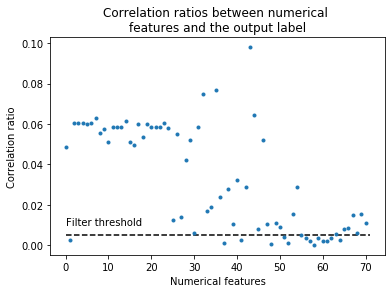

In [18]:
plt.plot(num_cor_ratio_array, '.')
plt.hlines(y=0.005, xmin=0, xmax=len(num_cor_ratio_array), ls='--')
plt.xlabel('Numerical features')
plt.ylabel('Correlation ratio')
plt.title('Correlation ratios between numerical \nfeatures and the output label')
plt.annotate('Filter threshold', (0, 0.01))
plt.savefig('../../reports/figures/corr_ratio_output_0.005.png', format='png')

In [19]:
top_num_features = [column for column in numerical_columns if num_cor_ratio_array[numerical_columns.index(column)]>0.06]
top_num_features

['Count_Anion Gap',
 'Count_Bicarbonate',
 'Count_Calcium, Total',
 'Count_Chloride',
 'Count_Creatinine',
 'Count_Glucose',
 'Count_Magnesium',
 'Count_Phosphate',
 'Count_Potassium',
 'Count_Urea Nitrogen',
 'Mean_Hemoglobin',
 'Mean_MCHC',
 'Mean_RDW',
 'Mean_Red Blood Cells']

In [20]:
print(num_cor_ratio_array[numerical_columns.index('Mean_Hemoglobin')])
print(num_cor_ratio_array[numerical_columns.index('Mean_Hematocrit')])

0.07463313359702543
0.05836116205923728


Note hemoglobin is one of the important features and shuld not be excluded, although it has redundant columns hematocrit and red blood cells, the corresponding correlation ratios are smaller than that of hemoglobin. Sort the numerical columns names by the correlation ratios is a descending order, such that hematocrit and red blood cells are considered in relationship to hemoglobon and not the other way around.

In [21]:
num_name_ratio_zipped_sorted = sorted(zip(numerical_columns, num_cor_ratio_array), key=lambda tup: tup[1], reverse=True)
print(num_name_ratio_zipped_sorted)

[('Mean_RDW', 0.09802611436336282), ('Mean_MCHC', 0.07703222670055314), ('Mean_Hemoglobin', 0.07463313359702543), ('Mean_Red Blood Cells', 0.06467264123639893), ('Count_Glucose', 0.06290907614596727), ('Count_Magnesium', 0.06158231192522031), ('Count_Creatinine', 0.060436589841808615), ('Count_Bicarbonate', 0.06041241002398264), ('Count_Anion Gap', 0.0603602971672171), ('Count_Urea Nitrogen', 0.060346873044214926), ('Count_Calcium, Total', 0.060281036750126395), ('Count_Chloride', 0.060224126043233225), ('Count_Potassium', 0.06010965185283715), ('Count_Phosphate', 0.06008425014335191), ('Count_RDW', 0.05853443509392651), ('Count_MCV', 0.05853011792354618), ('Count_MCH', 0.05848977862947261), ('Count_Red Blood Cells', 0.05848837519019294), ('Count_Sodium', 0.05841539620584016), ('Mean_Hematocrit', 0.05836116205923728), ('Count_MCHC', 0.05835808553059928), ('Count_White Blood Cells', 0.05823569208932981), ('Count_Hemoglobin', 0.057622176901365875), ('Count_Hematocrit', 0.0553201266499808

In [22]:
numerical_columns_sorted = [col for col, rank in num_name_ratio_zipped_sorted]
numerical_columns_sorted

['Mean_RDW',
 'Mean_MCHC',
 'Mean_Hemoglobin',
 'Mean_Red Blood Cells',
 'Count_Glucose',
 'Count_Magnesium',
 'Count_Creatinine',
 'Count_Bicarbonate',
 'Count_Anion Gap',
 'Count_Urea Nitrogen',
 'Count_Calcium, Total',
 'Count_Chloride',
 'Count_Potassium',
 'Count_Phosphate',
 'Count_RDW',
 'Count_MCV',
 'Count_MCH',
 'Count_Red Blood Cells',
 'Count_Sodium',
 'Mean_Hematocrit',
 'Count_MCHC',
 'Count_White Blood Cells',
 'Count_Hemoglobin',
 'Count_Hematocrit',
 'Mean_Bicarbonate',
 'Count_Platelet Count',
 'Mean_Urea Nitrogen',
 'Mean_Creatinine',
 'Count_PT',
 'Count_INR(PT)',
 'Count_PTT',
 'LENGTH_OF_STAY_DAYS',
 'Mean_Chloride',
 'Mean_Phosphate',
 'Var_Hematocrit',
 'Mean_Potassium',
 'Mean_PT',
 'Mean_MCV',
 'Mean_MCH',
 'Mean_INR(PT)',
 'Var_Glucose',
 'Var_Urea Nitrogen',
 'Var_Red Blood Cells',
 'Mean_Calcium, Total',
 'Mean_Anion Gap',
 'Var_White Blood Cells',
 'Var_Bicarbonate',
 'Mean_PTT',
 'Mean_White Blood Cells',
 'Var_Calcium, Total',
 'Var_RDW',
 'Mean_Sodium',

In [33]:
cat_theils_array = []
for column in categorical_columns:
    cat_cor_ratio = entropy_funcs.theils_u(df.OUTPUT_LABEL.values, df[column].values)
    cat_theils_array.append(cat_cor_ratio)

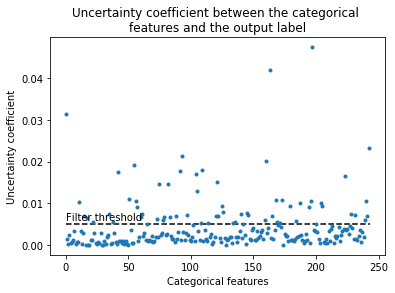

In [34]:
plt.plot(cat_theils_array, '.')
plt.hlines(y=0.005, xmin=0, xmax=len(cat_theils_array), ls='--')
plt.xlabel('Categorical features')
plt.ylabel('Uncertainty coefficient')
plt.title('Uncertainty coefficient between the categorical \nfeatures and the output label')
plt.annotate('Filter threshold', (0, 0.006))
plt.savefig('../../reports/figures/uncertainty_coef_output_0.005.png', format='png')

In [35]:
top_cat_features = [column for column in categorical_columns if cat_theils_array[categorical_columns.index(column)]>0.02]
top_cat_features

['1Y_PRIOR_ADM', 'complic', 'major', 'mcc', 'procedur', 'wo']

In [36]:
# sort the categorical column names in descending order of Theil's U cofficient
cat_name_theilu_zipped_sorted = sorted(zip(categorical_columns, cat_theils_array), key=lambda tup: tup[1], reverse=True)
categorical_columns_sorted = [col for col, rank in cat_name_theilu_zipped_sorted]

In [38]:
# uncoment to see the entire list with associated Theil's U coefficients
#cat_name_zipped_sorted = sorted(zip(categorical_columns, cat_theils_array), key=lambda tup: tup[1], reverse=True)
#print(cat_name_zipped_sorted)

In [28]:
# filter columns based on a threshod of 0.005 for each of the correlation ratio and Theil's U
cat_cols_todrop = [column for column in categorical_columns if cat_theils_array[categorical_columns.index(column)]<0.005]
print(len(cat_cols_todrop))
num_cols_todrop = [column for column in numerical_columns if num_cor_ratio_array[numerical_columns.index(column)]<0.005]
print(len(num_cols_todrop))

180
15


In [29]:
combined_cols_to_drop = cat_cols_todrop + num_cols_todrop
df_005_005 = df.drop(columns=combined_cols_to_drop, axis=1)
df_005_005.to_csv('../../data/processed/df_0.005_0.005.csv')

In [30]:
# filter columns based on a threshod of 0.0025 for each of the correlation ratio and Theil's U
cat_cols_todrop = [column for column in categorical_columns if cat_theils_array[categorical_columns.index(column)]<0.0025]
print(len(cat_cols_todrop))
num_cols_todrop = [column for column in numerical_columns if num_cor_ratio_array[numerical_columns.index(column)]<0.0025]
print(len(num_cols_todrop))

132
8


In [31]:
combined_cols_to_drop = cat_cols_todrop + num_cols_todrop
df_0025_0025 = df.drop(columns=combined_cols_to_drop, axis=1)
df_0025_0025.to_csv('../../data/processed/df_0.0025_0.0025.csv')

In [32]:
# filter columns based on a threshod of 0.001 for each of the correlation ratio and Theil's U
cat_cols_todrop = [column for column in categorical_columns if cat_theils_array[categorical_columns.index(column)]<0.001]
print(len(cat_cols_todrop))
num_cols_todrop = [column for column in numerical_columns if num_cor_ratio_array[numerical_columns.index(column)]<0.001]
print(len(num_cols_todrop))

60
2


In [33]:
combined_cols_to_drop = cat_cols_todrop + num_cols_todrop
df_001_001 = df.drop(columns=combined_cols_to_drop, axis=1)
df_001_001.to_csv('../../data/processed/df_0.001_0.001.csv')

In [36]:
# filter columns based on a threshod of 0.0005 for each of the correlation ratio and Theil's U
cat_cols_todrop = [column for column in categorical_columns if cat_theils_array[categorical_columns.index(column)]<0.0005]
print(len(cat_cols_todrop))
num_cols_todrop = [column for column in numerical_columns if num_cor_ratio_array[numerical_columns.index(column)]<0.0005]
print(len(num_cols_todrop))

28
1


In [37]:
combined_cols_to_drop = cat_cols_todrop + num_cols_todrop
df_0005_0005 = df.drop(columns=combined_cols_to_drop, axis=1)
df_0005_0005.to_csv('../../data/processed/df_0.0005_0.0005.csv')

### eliminating columns based on correlation ratio or Theil's U was not successful, since both the AUROC and average precision went down even at a threshold of 0.0005. Next, we will look at eliminating linearly correlated numerical (Pearson's correlation) or strongly associated categorical features (Cramer's V).

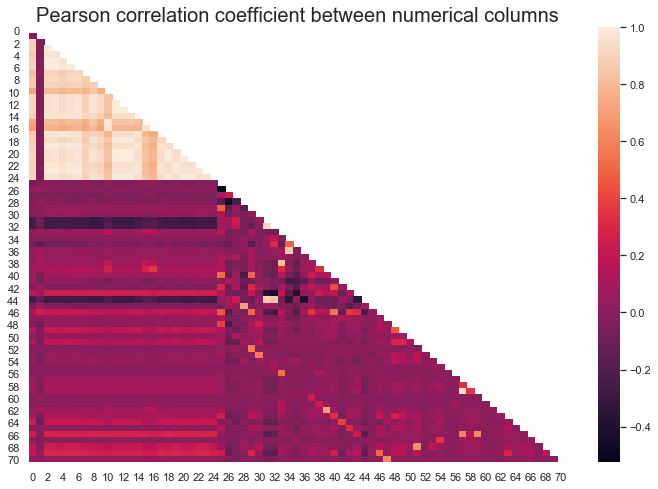

In [39]:
import seaborn as sns

# Calculate Pearson correlation coefficient
num_corr_mat = np.corrcoef(df[numerical_columns].values, rowvar=False)

mask = np.triu(np.ones_like(num_corr_mat, dtype=np.bool))
sns.set(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

ax = sns.heatmap(num_corr_mat, annot=False, mask=mask)
ax.set_title("Pearson correlation coefficient between numerical columns", fontsize=20)
plt.savefig('../../reports/figures/pears_corr_coeff.png', format='png')

In [40]:
from itertools import compress

# Define a function for generating the array and dictionary with correlated columns
def corr_extractor(corr_mat, cols_list, thresh):
    """With correlation matrix, list of columns (for which the 
    correlation matrix was calculated), and threshold (for 
    cooefficient comparison) as input return an array of 
    redundant column (to drop) and a dictionary to inspect 
    the correlations."""
    corr_mat_asym = np.tril(corr_mat, -1) # set the top half triangle of the matrix (including main diagonal) to 0
    bool_mask = abs(corr_mat_asym)>=thresh # create a boolean mask for values above the threshold

    corr_array = [] # initiate empty array and dictionary
    corr_dict = {}
    
    for i in range(len(cols_list)): 
        # iterate through the columns in cols_array and extract the associated column names with the boolean mask
        cors = list(compress(cols_list, bool_mask[:,i]))
        if cors!= []:
            corr_dict[cols_list[i]]=[]
            # create a key value pair, key= (query) column name values = list of associated columns
            corr_dict[cols_list[i]]+=cors
            for elem in cors:
                corr_array.append(elem) # create a list only with the redundant column (excluding the query)
    
    corr_array = list(dict.fromkeys(corr_array)) # drop duplicates
    
    return corr_array, corr_dict

In [43]:
#determine the numerical features that have a Pearson correlation coeffient above 0.90
num_corr_to_drop, num_corr_dict = corr_extractor(num_corr_mat, numerical_columns, 0.90)
print("The number of redundant numerical features is ", len(num_corr_to_drop))
print("The number of remaining numerical features is ", len(numerical_columns)-len(num_corr_to_drop))

The number of redundant numerical features is  23
The number of remaining numerical features is  48


In [44]:
num_corr_to_drop

['Count_Creatinine',
 'Count_MCH',
 'Count_MCHC',
 'Count_MCV',
 'Count_RDW',
 'Count_Red Blood Cells',
 'Count_Urea Nitrogen',
 'Count_White Blood Cells',
 'Count_Bicarbonate',
 'Count_Calcium, Total',
 'Count_Chloride',
 'Count_Glucose',
 'Count_Hematocrit',
 'Count_Hemoglobin',
 'Count_Magnesium',
 'Count_Phosphate',
 'Count_Platelet Count',
 'Count_Potassium',
 'Count_Sodium',
 'Count_PT',
 'Count_PTT',
 'Mean_Hemoglobin',
 'Var_MCV']

In [45]:
# fit logistic regression without redundant columns
df_p09 = df.drop(columns=num_corr_to_drop)
df_p09.to_csv('../../data/processed/df_p09.csv')

### Most redundant features are test counts, which is expected since multiple lab test are conducted at the same time, especially since we chose the most frequently administered tests. After dropping the numerical columns with Pearson correlation coefficient of 0.9 the logistic regression metrics did not change at all, hence those 23 columns are dispensible.

### let's see if first sorting the columns by descending correlation ratio and then elimating correlated columns (which have smaller correlation ratio) makes a difference. 

In [47]:
# Calculate Pearson correlation coefficient for sorted columns
num_corr_mat = np.corrcoef(df[numerical_columns_sorted].values, rowvar=False)

#determine the numerical features that have a Pearson correlation coeffient above 0.90
num_corr_to_drop, num_corr_dict = corr_extractor(num_corr_mat, numerical_columns_sorted, 0.90)
print("The number of redundant numerical features is ", len(num_corr_to_drop))
print("The number of remaining numerical features is ", len(numerical_columns_sorted)-len(num_corr_to_drop))

# display the columns to drop
print(num_corr_to_drop)

# fit logistic regression without redundant columns
df_p09_sorted = df.drop(columns=num_corr_to_drop)
df_p09_sorted.to_csv('../../data/processed/df_p09_sorted.csv')

The number of redundant numerical features is  24
The number of remaining numerical features is  47
['Mean_Hematocrit', 'Count_Magnesium', 'Count_Creatinine', 'Count_Bicarbonate', 'Count_Anion Gap', 'Count_Urea Nitrogen', 'Count_Chloride', 'Count_Sodium', 'Count_Calcium, Total', 'Count_Potassium', 'Count_Phosphate', 'Count_RDW', 'Count_MCV', 'Count_MCH', 'Count_Red Blood Cells', 'Count_MCHC', 'Count_White Blood Cells', 'Count_Hematocrit', 'Count_Platelet Count', 'Count_Hemoglobin', 'LENGTH_OF_STAY_DAYS', 'Count_INR(PT)', 'Count_PTT', 'Var_MCH']


### To measure the association of categorical variables we will compute Cramer's V coefficient, which is based on Chi squared statistic and takes values from 0 to 1. Note that Cramer's V calculation takes a long time.

In [46]:
# calculate Cramer's V coefficient for all categorical features, this may take a while
start_time = time.monotonic()
x = df[categorical_columns]
corr_mat_cat = np.zeros((len(x.columns), len(x.columns)))
for i in range(len(x.columns)):
    for j in range(len(x.columns)):
        corr_mat_cat[i,j] = entropy_funcs.cramers_v(x.iloc[:,i], x.iloc[:,j])
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

Calculation took 27.290 minutes


In [54]:
#determine the categorical features that have a Cramer's V coeffient above 0.9
cat_corr_to_drop, cat_corr_dict = corr_extractor(corr_mat_cat, categorical_columns, 0.9)
print("The number of redundant categorical features is ", len(cat_corr_to_drop))
print("The number of remaining categorical features is ", len(categorical_columns)-len(cat_corr_to_drop))

The number of redundant categorical features is  106
The number of remaining categorical features is  137


In [55]:
print(cat_corr_to_drop)

['procedur', 'depend', 'aliv', 'discharg', 'myocardi', 'medicin', 'cirrhosi', 'infarct', 'drugelut', 'perc', 'cardiac', 'defibril', 'heart', 'conduct', 'disord', 'stent', 'problem', 'tract', 'larg', 'small', 'cath', 'coronari', 'percutan', 'cardiothorac', 'maj', 'oth', 'proc', 'valv', 'cathet', 'catheter', 'pacemak', 'mcc', 'hemorrhag', 'intracrani', 'diseas', 'obstruct', 'pulmonari', 'exc', 'hepat', 'head', 'hr', 'stupor', 'complic', 'treatment', 'hiv', 'major', 'relat', 'tissu', 'endovascular', 'occulus', 'precerebr', 'malfunct', 'reaction', 'sign', 'symptom', 'tracheostomi', 'mcv', 'support', 'unrel', 'includ', 'infecti', 'parasit', 'ischem', 'peripher', 'infect', 'septicemia', 'esophag', 'stomach', 'face', 'mouth', 'neck', 'failur', 'respiratori', 'poison', 'toxic', 'hrs', 'mv', 'trach', 'long', 'term', 'vascular', 'lower', 'mechan', 'shock', 'hip', 'neonat', 'spinal', 'peptic', 'ulcer', 'unspecifi', 'trauma', 'pancrea', 'sepsi', 'sever', 'ventil', 'pdx', 'inflamm', 'urinari', 'sig

In [49]:
df_p09_cv09 = df_p09.drop(columns=cat_corr_to_drop, axis=1)
df_p09_cv09.to_csv('../../data/processed/df_p09_cv09.csv')
df_p09_sorted_cv09 = df_p09_sorted.drop(columns=cat_corr_to_drop, axis=1)
df_p09_sorted_cv09.to_csv('../../data/processed/df_p09_sorted_cv09.csv')

In [50]:
# calculate Cramer's V coefficient for all sorted categorical features, this may take a while
start_time = time.monotonic()
y = df[categorical_columns_sorted]
corr_mat_cat_sorted = np.zeros((len(y.columns), len(y.columns)))
for i in range(len(y.columns)):
    for j in range(len(y.columns)):
        corr_mat_cat_sorted[i,j] = entropy_funcs.cramers_v(y.iloc[:,i], y.iloc[:,j])
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

Calculation took 32.443 minutes


In [56]:
#determine the categorical features that have a Cramer's V coeffient above 0.9
cat_corr_to_drop, cat_corr_dict = corr_extractor(corr_mat_cat_sorted, categorical_columns_sorted, 0.9)
print("The number of redundant categorical features is ", len(cat_corr_to_drop))
print("The number of remaining categorical features is ", len(categorical_columns_sorted)-len(cat_corr_to_drop))
print(cat_corr_to_drop)

The number of redundant categorical features is  103
The number of remaining categorical features is  140
['percutan', 'oper', 'room', 'princip', 'tracheostomi', 'extens', 'mechan', 'bypass', 'cardiovascular', 'ecmo', 'stent', 'unrel', 'term', 'long', 'cardiovasc', 'cardiothorac', 'perc', 'bowel', 'valv', 'extracrani', 'larg', 'small', 'drugelut', 'oth', 'shunt', 'abdomin', 'duoden', 'stomach', 'arteri', 'endovascular', 'resp', 'includ', 'comorbid', 'treatment', 'condit', 'neonat', 'peripher', 'ischem', 'arrhythmia', 'conduct', 'circ', 'sign', 'symptom', 'support', 'nervous', 'cath', 'catheter', 'cathet', 'card', 'pacemak', 'defibril', 'anomali', 'mcv', 'mouth', 'face', 'mv', 'hrs', 'trach', 'hour', 'edema', 'inflamm', 'shock', 'myocardi', 'cerebr', 'precerebr', 'cva', 'aliv', 'discharg', 'occulus', 'sepsi', 'sever', 'multipl', 'signific', 'head', 'dissemin', 'unspecifi', 'chronic', 'infecti', 'parasit', 'hiv', 'reaction', 'malfunct', 'kidney', 'urinari', 'biliari', 'connect', 'medicin

In [57]:
df_p09_cv09_sorted = df_p09.drop(columns=cat_corr_to_drop, axis=1)
df_p09_cv09_sorted.to_csv('../../data/processed/df_p09_cv09_sorted.csv')
df_p09_sorted_cv09_sorted = df_p09_sorted.drop(columns=cat_corr_to_drop, axis=1)
df_p09_sorted_cv09_sorted.to_csv('../../data/processed/df_p09_sorted_cv09_sorted.csv')

### AUROC and AP went down a little, try a threshold of 0.95 on sorted categorical columns.

In [58]:
#determine the categorical features that have a Cramer's V coeffient above 0.95
cat_corr_to_drop, cat_corr_dict = corr_extractor(corr_mat_cat_sorted, categorical_columns_sorted, 0.95)
print("The number of redundant categorical features is ", len(cat_corr_to_drop))
print("The number of remaining categorical features is ", len(categorical_columns_sorted)-len(cat_corr_to_drop))
print(cat_corr_to_drop)

The number of redundant categorical features is  85
The number of remaining categorical features is  158
['percutan', 'oper', 'room', 'extens', 'mechan', 'bypass', 'cardiovascular', 'stent', 'term', 'long', 'cardiovasc', 'extracrani', 'larg', 'small', 'drugelut', 'shunt', 'duoden', 'stomach', 'endovascular', 'resp', 'includ', 'perc', 'comorbid', 'treatment', 'neonat', 'arrhythmia', 'conduct', 'circ', 'support', 'nervous', 'cath', 'catheter', 'cathet', 'card', 'valv', 'oth', 'pacemak', 'defibril', 'anomali', 'unrel', 'mcv', 'face', 'tracheostomi', 'ecmo', 'trach', 'edema', 'shock', 'myocardi', 'cerebr', 'precerebr', 'cva', 'aliv', 'discharg', 'occulus', 'sepsi', 'sever', 'signific', 'head', 'dissemin', 'unspecifi', 'chronic', 'infecti', 'parasit', 'condit', 'malfunct', 'arteri', 'kidney', 'urinari', 'biliari', 'symptom', 'connect', 'medicin', 'embol', 'stupor', 'hr', 'cirrhosi', 'poison', 'toxic', 'peptic', 'gastriti', 'fusion', 'depend', 'hepatobiliari', 'pleurisi', 'simpl']


In [59]:
df_p09_cv095_sorted = df_p09.drop(columns=cat_corr_to_drop, axis=1)
df_p09_cv095_sorted.to_csv('../../data/processed/df_p09_cv095_sorted.csv')